### TITLE : Backtesting Strategies

<p> Author : BRYAN LIM YUQIANG </p> 
<p> Contact me : </p>
<li>Bryanlimyuqiang@gmail.com</li>
<li><a href = "https://www.linkedin.com/in/bryanlimyuqiang/">Linkedin </a></li> 
<li><a href = "https://www.etoro.com/people/bryanlimyuqiang"> Follow my trading journey </a></li>


<img src='./images/intro_backtesting.jpg' alt = '' />

<img src='./images/portfolio_rebalancing.jpg' />

In [30]:
# Import necesary libraries
import pandas_datareader.data as pdr
import numpy as np
import datetime
import copy 
import pandas as pd
import matplotlib.pyplot as plt

def CAGR(DF):
#   function to calculate the Cumulative Annual Growth Rate of a trading strategy
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    n = len(df)/12
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["mon_ret"].std() * np.sqrt(252)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    
def sortino(DF,rf):
    "function to calculate sortino ratio ; rf is the risk free rate"
    df = DF.copy()
    df["daily_ret"] = DF["Adj Close"].pct_change()
    neg_vol = df[df["daily_ret"]<0]["daily_ret"].std() * np.sqrt(252)
    sr = (CAGR(df) - rf)/neg_vol
    return sr

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["mon_ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd
    
def calmar(DF):
    "function to calculate calmar ratio"
    df = DF.copy()
    clmr = CAGR(df)/max_dd(df)
    return clmr

In [31]:
# Download historical data (monthly) for DJI constituent stocks as of 2015

tickers = ["MMM","AXP","T","BA","CAT","CVX","CSCO","KO", "XOM","GE","GS","HD",
           "IBM","INTC","JNJ","JPM","MCD","MRK","MSFT","NKE","PFE","PG","TRV",
           "UTX","UNH","VZ","V","WMT","DIS"]

In [32]:
ohlc_mon = {} # directory with ohlc value for each stock            
attempt = 0 # initializing passthrough variable
drop = [] # initializing list to store tickers whose close price was successfully extracted
while len(tickers) != 0 and attempt <= 5:
    tickers = [j for j in tickers if j not in drop] # removing stocks whose data has been extracted from the ticker list
    for i in range(len(tickers)):
        try:
            # we initialise monthly df here 
            ohlc_mon[tickers[i]] = pdr.get_data_yahoo(tickers[i],datetime.date.today()-datetime.timedelta(1900),datetime.date.today(),interval='m')
            ohlc_mon[tickers[i]].dropna(inplace = True)
            drop.append(tickers[i])       
        except:
            print(tickers[i]," :failed to fetch data...retrying")
            continue
    attempt+=1
 
tickers = ohlc_mon.keys() # redefine tickers variable after removing any tickers with corrupted data

In [33]:
# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    print("calculating monthly return for ",ticker)
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]

calculating monthly return for  MMM
calculating monthly return for  AXP
calculating monthly return for  T
calculating monthly return for  BA
calculating monthly return for  CAT
calculating monthly return for  CVX
calculating monthly return for  CSCO
calculating monthly return for  KO
calculating monthly return for  XOM
calculating monthly return for  GE
calculating monthly return for  GS
calculating monthly return for  HD
calculating monthly return for  IBM
calculating monthly return for  INTC
calculating monthly return for  JNJ
calculating monthly return for  JPM
calculating monthly return for  MCD
calculating monthly return for  MRK
calculating monthly return for  MSFT
calculating monthly return for  NKE
calculating monthly return for  PFE
calculating monthly return for  PG
calculating monthly return for  TRV
calculating monthly return for  UTX
calculating monthly return for  UNH
calculating monthly return for  VZ
calculating monthly return for  V
calculating monthly return for  WMT


In [34]:
# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly
    """
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(1,len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            
            # sort to filter bad stocks based on monthly return to remove 
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            
            # rebalaced portofolio
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        
        #  choosing new stocks based on fill and adding back to portfolio
        # default new_picks allow for double down
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        
        #alternative new_picks restricting double_down and only selecting new stocks
        #new_picks = df[[t for t in tickers if t not in portfolio]].iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        
        portfolio = portfolio + new_picks
        print(portfolio)
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df

In [35]:
#calculating overall strategy's KPIs
#repeated stocks in portfolio represent that double down was present 
CAGR(pflio(return_df,6,3))
sharpe(pflio(return_df,6,3),0.025)
max_dd(pflio(return_df,6,3))

['MSFT', 'GE', 'CAT', 'IBM', 'T', 'CVX']
['GE', 'IBM', 'T', 'UNH', 'INTC', 'GS']
['T', 'UNH', 'GS', 'NKE', 'DIS', 'JPM']
['NKE', 'DIS', 'JPM', 'V', 'TRV', 'PFE']
['NKE', 'V', 'TRV', 'AXP', 'GE', 'HD']
['NKE', 'TRV', 'HD', 'NKE', 'INTC', 'MSFT']
['TRV', 'INTC', 'MSFT', 'MSFT', 'GE', 'CVX']
['MSFT', 'MSFT', 'GE', 'HD', 'JPM', 'GE']
['GE', 'GE', 'PG', 'UNH', 'MCD', 'WMT']
['PG', 'MCD', 'WMT', 'WMT', 'VZ', 'T']
['VZ', 'T', 'CAT', 'CSCO', 'UTX', 'IBM']
['CAT', 'CSCO', 'IBM', 'IBM', 'CVX', 'CAT']
['CAT', 'CVX', 'CAT', 'PFE', 'CVX', 'JPM']
['PFE', 'JPM', 'CSCO', 'MSFT', 'PFE', 'WMT']
['PFE', 'PFE', 'WMT', 'T', 'VZ', 'JNJ']
['PFE', 'PFE', 'JNJ', 'MSFT', 'CAT', 'HD']
['MSFT', 'CAT', 'HD', 'MRK', 'GS', 'JPM']
['MSFT', 'CAT', 'MRK', 'CAT', 'INTC', 'CVX']
['MSFT', 'MRK', 'CVX', 'GS', 'BA', 'MSFT']
['CVX', 'GS', 'BA', 'GS', 'JPM', 'CAT']
['GS', 'GS', 'JPM', 'GS', 'TRV', 'VZ']
['JPM', 'TRV', 'DIS', 'MRK', 'V', 'IBM']
['JPM', 'MRK', 'V', 'CSCO', 'BA', 'GS']
['V', 'CSCO', 'BA', 'MSFT', 'MMM', 'DIS']
[

0.2191759390318326

In [36]:
#calculating KPIs for Index buy and hold strategy over the same period
DJI = pdr.get_data_yahoo("^DJI",datetime.date.today()-datetime.timedelta(1900),datetime.date.today(),interval='m')
DJI["mon_ret"] = DJI["Adj Close"].pct_change()
CAGR(DJI)
sharpe(DJI,0.025)
max_dd(DJI)


0.23201266165063408

['MSFT', 'GE', 'CAT', 'IBM', 'T', 'CVX']
['GE', 'IBM', 'T', 'UNH', 'INTC', 'GS']
['T', 'UNH', 'GS', 'NKE', 'DIS', 'JPM']
['NKE', 'DIS', 'JPM', 'V', 'TRV', 'PFE']
['NKE', 'V', 'TRV', 'AXP', 'GE', 'HD']
['NKE', 'TRV', 'HD', 'NKE', 'INTC', 'MSFT']
['TRV', 'INTC', 'MSFT', 'MSFT', 'GE', 'CVX']
['MSFT', 'MSFT', 'GE', 'HD', 'JPM', 'GE']
['GE', 'GE', 'PG', 'UNH', 'MCD', 'WMT']
['PG', 'MCD', 'WMT', 'WMT', 'VZ', 'T']
['VZ', 'T', 'CAT', 'CSCO', 'UTX', 'IBM']
['CAT', 'CSCO', 'IBM', 'IBM', 'CVX', 'CAT']
['CAT', 'CVX', 'CAT', 'PFE', 'CVX', 'JPM']
['PFE', 'JPM', 'CSCO', 'MSFT', 'PFE', 'WMT']
['PFE', 'PFE', 'WMT', 'T', 'VZ', 'JNJ']
['PFE', 'PFE', 'JNJ', 'MSFT', 'CAT', 'HD']
['MSFT', 'CAT', 'HD', 'MRK', 'GS', 'JPM']
['MSFT', 'CAT', 'MRK', 'CAT', 'INTC', 'CVX']
['MSFT', 'MRK', 'CVX', 'GS', 'BA', 'MSFT']
['CVX', 'GS', 'BA', 'GS', 'JPM', 'CAT']
['GS', 'GS', 'JPM', 'GS', 'TRV', 'VZ']
['JPM', 'TRV', 'DIS', 'MRK', 'V', 'IBM']
['JPM', 'MRK', 'V', 'CSCO', 'BA', 'GS']
['V', 'CSCO', 'BA', 'MSFT', 'MMM', 'DIS']
[

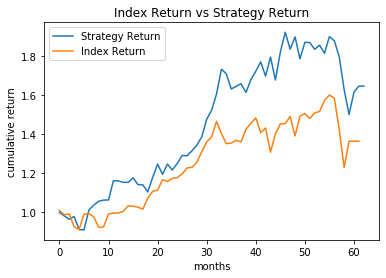

In [37]:
#visualization
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+DJI["mon_ret"][2:].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])